In [41]:
# This is an example that uses the websockets api to know when a prompt execution is done
# Once the prompt execution is done it downloads the images using the /history endpoint
# https://github.com/Nuked88/DreamingAI/blob/main/dreaminAI_websockets_api_example.py
import websocket  # NOTE: websocket-client (https://github.com/websocket-client/websocket-client)
import uuid
import json
import urllib.request
import urllib.parse
import requests

server_address = "127.0.0.1:8188"
client_id = str(uuid.uuid4())


def queue_prompt(prompt):
    p = {"prompt": prompt, "client_id": client_id}
    data = json.dumps(p).encode("utf-8")
    req = urllib.request.Request("http://{}/prompt".format(server_address), data=data)
    return json.loads(urllib.request.urlopen(req).read())


def get_image(filename, subfolder, folder_type):
    data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    url_values = urllib.parse.urlencode(data)
    with urllib.request.urlopen(
        "http://{}/view?{}".format(server_address, url_values)
    ) as response:
        return response.read()


def get_history(prompt_id):
    with urllib.request.urlopen(
        "http://{}/history/{}".format(server_address, prompt_id)
    ) as response:
        return json.loads(response.read())


def get_images(ws, prompt):
    prompt_id = queue_prompt(prompt)["prompt_id"]
    output_images = {}
    while True:
        out = ws.recv()
        if isinstance(out, str):
            message = json.loads(out)
            if message["type"] == "executing":
                data = message["data"]
                if data["node"] is None and data["prompt_id"] == prompt_id:
                    break  # Execution is done
        else:
            continue  # previews are binary data

    history = get_history(prompt_id)[prompt_id]
    for o in history["outputs"]:
        for node_id in history["outputs"]:
            node_output = history["outputs"][node_id]
            if "images" in node_output:
                images_output = []
                for image in node_output["images"]:
                    image_data = get_image(
                        image["filename"], image["subfolder"], image["type"]
                    )
                    images_output.append(image_data)
            output_images[node_id] = images_output

    return output_images


# workflow_path = "showcases/showcase_9/nfs_canny_normal_map_sdxl_api_1.json"
workflow_path = "showcases/showcase_9/nfs_canny_normal_map_sdxl_batch_list_api.json"
# upload an image
with open(workflow_path, "r") as f:
    workflow = json.load(f)

workflow["240"]["inputs"]["steps"] = 5
workflow["253"]["inputs"]["image_load_cap"] = 4
# start
workflow["256"]["inputs"]["int"] = 170
workflow["258"]["inputs"]["filename_prefix"] = f"nfs_4screens_6_sdxl_{client_id}"

print(client_id)
ws = websocket.WebSocket()
ws.connect("ws://{}/ws?clientId={}".format(server_address, client_id))
images = get_images(ws, workflow)

# Commented out code to display the output images:
images_list = []
for node_id in images:
    for image_data in images[node_id]:
        from PIL import Image
        import io

        image = Image.open(io.BytesIO(image_data))
        # image.show()
        images_list.append(image)
        # save image
        # image.save(f"{node_id}-{seed}.png")
# image

416fbf8e-28cb-4a33-85a4-ac04ad63f13c


In [ ]:
import os
from pathlib import Path
from PIL import Image
from more_itertools import chunked


dataset = "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6"
target_save_path_1 = "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_test"
original_images = sorted(list(Path(dataset).glob("*.png")))
target_images = sorted(list(Path(target_save_path_1).glob("*.png")))

total_parts = 4
original_images_parts = list(
    chunked(
        original_images,
        len(original_images) // total_parts + 1,
    )
)

part_num = 0
original_images_part = original_images_parts[part_num]
target_images_names = set([item.stem for item in target_images])
images_to_process = [
    item for item in original_images_part if not item.stem in target_images_names
]

In [72]:
part_num = 0
original_images_part = original_images_parts[part_num]
target_images_names = set([item.stem for item in target_images])
images_to_process = [
    item for item in original_images_part if not item.stem in target_images_names
]

In [76]:
images_to_process[0]

PosixPath('/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000007.png')

In [75]:
target_images_names

{'000000001', '000000002', '000000003', '000000004', '000000005', '000000006'}

In [79]:
print("\n".join([str(item) for item in images_to_process[:4]]))

/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000007.png
/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000008.png
/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000009.png
/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000010.png


In [ ]:
images_list[0]

In [ ]:
images_list[1]

In [ ]:
images_list[2]

### Create ComfyUI Worker Class

In [ ]:
import os
from pathlib import Path
from PIL import Image
from more_itertools import chunked
import websocket
import uuid
import json
import urllib.request
import urllib.parse
import requests
import io


class ComfyUIImageAPI:
    def __init__(
        self,
        server_address="127.0.0.1:8188",
        workflow_path="",
    ):
        self.server_address = server_address
        self.client_id = str(uuid.uuid4())
        self.workflow_path = workflow_path

    def queue_prompt(
        self,
        prompt,
    ):
        p = {"prompt": prompt, "client_id": self.client_id}
        data = json.dumps(p).encode("utf-8")
        req = urllib.request.Request(
            "http://{}/prompt".format(self.server_address), data=data
        )
        return json.loads(urllib.request.urlopen(req).read())

    def get_image(
        self,
        filename,
        subfolder,
        folder_type,
    ):
        data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
        url_values = urllib.parse.urlencode(data)
        with urllib.request.urlopen(
            "http://{}/view?{}".format(self.server_address, url_values)
        ) as response:
            return response.read()

    def get_history(
        self,
        prompt_id,
    ):
        with urllib.request.urlopen(
            "http://{}/history/{}".format(self.server_address, prompt_id)
        ) as response:
            return json.loads(response.read())

    def get_images(
        self,
        ws,
        prompt,
    ):
        prompt_id = self.queue_prompt(prompt)["prompt_id"]
        output_images = {}
        while True:
            out = ws.recv()
            if isinstance(out, str):
                message = json.loads(out)
                if message["type"] == "executing":
                    data = message["data"]
                    if data["node"] is None and data["prompt_id"] == prompt_id:
                        break  # Execution is done
            else:
                continue  # previews are binary data

        history = self.get_history(prompt_id)[prompt_id]
        for o in history["outputs"]:
            for node_id in history["outputs"]:
                node_output = history["outputs"][node_id]
                images_output = []
                if "images" in node_output:
                    for image in node_output["images"]:
                        image_data = self.get_image(
                            image["filename"], image["subfolder"], image["type"]
                        )
                        images_output.append(image_data)
                output_images[node_id] = images_output

        return output_images

    def process_image_folder(
        self,
        original_images_path="",
        batch_size=4,
        target_save_path="",
        total_parts=4,
        part_num=0,
    ):
        self.client_id = str(uuid.uuid4())

        original_images = sorted(list(Path(original_images_path).glob("*.png")))
        target_images = sorted(list(Path(target_save_path).glob("*.png")))

        # total_parts = 4
        original_images_parts = list(
            chunked(
                original_images,
                len(original_images) // total_parts + 1,
            )
        )

        # part_num = 0
        original_images_part = original_images_parts[part_num]
        target_images_names = set([item.stem for item in target_images])
        images_to_process = [
            item
            for item in original_images_part
            if not item.stem in target_images_names
        ][:batch_size]
        if len(images_to_process) == 0:
            return "END"

        with open(self.workflow_path, "r") as f:
            workflow = json.load(f)

        # diffustion steps
        # workflow["240"]["inputs"]["steps"] = 5
        workflow["201"]["inputs"]["batch"] = True
        # input images
        workflow["257"]["inputs"]["paths"] = "\n".join(
            [str(item) for item in images_to_process]
        )
        print(workflow["257"]["inputs"]["paths"])
        # save prefix
        save_prefix = f"nfs_4screens_6_sdxl_{self.client_id}"
        workflow["258"]["inputs"]["filename_prefix"] = save_prefix

        print(self.client_id)
        ws = websocket.WebSocket()
        ws.connect(
            "ws://{}/ws?clientId={}".format(
                self.server_address,
                self.client_id,
            )
        )
        images = self.get_images(ws, workflow)

        for node_id in images:
            for image_data, image_original_path in zip(
                images[node_id], images_to_process
            ):
                image = Image.open(io.BytesIO(image_data))
                image.save(f"{target_save_path}/{image_original_path.stem}.png")

        # clean output images from comfyui
        os.system(f"rm /code/ComfyUI/output/{save_prefix}*.png")


comfy_images_process = ComfyUIImageAPI(
    server_address="127.0.0.1:8188",
    workflow_path="showcases/showcase_9/nfs_canny_normal_map_sdxl_batch_list_api.json",
)
dataset = "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6"
target_save_path_1 = "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1"
comfy_images_process.process_image_folder(
    original_images_path=dataset,
    batch_size=20,
    target_save_path=target_save_path_1,
    total_parts=4,
    part_num=0,
)

/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000003.png
/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000004.png
/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000005.png
/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000006.png
/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000007.png
/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000008.png
/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000009.png
/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000010.png
/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000011.png
/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000012.png
/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000013.png
/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000014.png
/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000015.png
/code/comfyui_sandbox/video_renders/render_nfs_4screens_6/000000

# Simple Upscale v1

In [3]:
# !pip install websocket-client==1.9.0

In [19]:
import os
from pathlib import Path
from PIL import Image
from more_itertools import chunked
import websocket
import uuid
import json
import urllib.request
import urllib.parse
import requests
import io
import tempfile
import os


class ComfyUIImageAPIUpscaleV1:
    def __init__(
        self,
        server_address="127.0.0.1:8188",
        workflow_path="",
    ):
        self.server_address = server_address
        self.client_id = str(uuid.uuid4())
        self.workflow_path = workflow_path

    def queue_prompt(
        self,
        prompt,
    ):
        p = {"prompt": prompt, "client_id": self.client_id}
        data = json.dumps(p).encode("utf-8")
        req = urllib.request.Request(
            "http://{}/prompt".format(self.server_address), data=data
        )
        return json.loads(urllib.request.urlopen(req).read())

    def get_image(
        self,
        filename,
        subfolder,
        folder_type,
    ):
        data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
        url_values = urllib.parse.urlencode(data)
        with urllib.request.urlopen(
            "http://{}/view?{}".format(self.server_address, url_values)
        ) as response:
            return response.read()

    def get_history(
        self,
        prompt_id,
    ):
        with urllib.request.urlopen(
            "http://{}/history/{}".format(self.server_address, prompt_id)
        ) as response:
            return json.loads(response.read())

    def get_images(
        self,
        ws,
        prompt,
    ):
        prompt_id = self.queue_prompt(prompt)["prompt_id"]
        output_images = {}
        while True:
            out = ws.recv()
            if isinstance(out, str):
                message = json.loads(out)
                if message["type"] == "executing":
                    data = message["data"]
                    if data["node"] is None and data["prompt_id"] == prompt_id:
                        break  # Execution is done
            else:
                continue  # previews are binary data

        history = self.get_history(prompt_id)[prompt_id]
        for o in history["outputs"]:
            for node_id in history["outputs"]:
                node_output = history["outputs"][node_id]
                images_output = []
                if "images" in node_output:
                    for image in node_output["images"]:
                        image_data = self.get_image(
                            image["filename"], image["subfolder"], image["type"]
                        )
                        images_output.append(image_data)
                output_images[node_id] = images_output

        return output_images

    def process_image_folder(
        self,
        dataset: list = None,
        batch_size=4,
        target_save_path_1="",
        target_save_path_2="",
        total_parts=4,
        part_num=0,
    ):
        os.system(f"mkdir -p {target_save_path_1}")
        os.system(f"mkdir -p {target_save_path_2}")

        # генерируем случайный номер для исполнителя
        self.client_id = str(uuid.uuid4())

        # original_images = sorted(list(Path(original_images_path).glob("*.png")))
        original_images = dataset
        target_images = sorted(list(Path(target_save_path_1).glob("*.png")))

        # разбиваем на части
        # total_parts = 4
        original_images_parts = list(
            chunked(
                ["{:07d}".format(i) for i in range(len(original_images))],
                len(original_images) // total_parts + 1,
            ),
        )

        # part_num = 0
        # берем в текущем процессе только нужную часть
        original_images_part = original_images_parts[part_num]
        # составляем уникальный список имен чтобы с ними больше не работать
        target_images_names = set([item.stem for item in target_images])
        # фильтруем
        images_to_process = [
            item for item in original_images_part if not item in target_images_names
        ][:batch_size]
        if len(images_to_process) == 0:
            return "END"

        with open(self.workflow_path, "r") as f:
            workflow = json.load(f)

        # diffustion steps
        # workflow["240"]["inputs"]["steps"] = 5
        # workflow["201"]["inputs"]["batch"] = True
        # input images
        # создаем временную папку чтобы данные картинки удалились после
        # обработки
        with tempfile.TemporaryDirectory() as temp_dir:
            print(f"Temporary folder created at: {temp_dir}")
            for im_num in images_to_process:
                dataset[int(im_num)]["edited_image"].save(f"{temp_dir}/{im_num}.png")

            images_to_process = [
                f"{temp_dir}/{im_num}.png" for im_num in images_to_process
            ]

            # создаем батч
            workflow["268"]["inputs"]["paths"] = "\n".join(
                # [str(item) for item in images_to_process]
                [item for item in images_to_process]
            )
            print(workflow["268"]["inputs"]["paths"])
            # save prefix
            # save_prefix = f"nfs_4screens_5_sdxl_{self.client_id}"
            # сохраняем
            save_prefix = f"nfs_4screens_6_sdxl_{self.client_id}"
            workflow["261"]["inputs"]["filename_prefix"] = save_prefix
            workflow["252"]["inputs"]["filename_prefix"] = save_prefix + "v2"

            print(self.client_id)
            ws = websocket.WebSocket()
            ws.connect(
                "ws://{}/ws?clientId={}".format(
                    self.server_address,
                    self.client_id,
                )
            )
            # получаем изображения
            images = self.get_images(ws, workflow)
            for node_id in images:
                for image_data, image_original_path in zip(
                    images[node_id],
                    images_to_process,
                ):

                    image = Image.open(io.BytesIO(image_data))
                    if int(node_id) == 272:
                        image.save(
                            # f"{target_save_path_1}/{image_original_path.stem}.png"
                            f"{target_save_path_1}/{Path(image_original_path).stem}.png"
                        )
                    if int(node_id) == 270:
                        image.save(
                            f"{target_save_path_2}/{Path(image_original_path).stem}.png"
                        )

            # clean output images from comfyui
            # os.system(f"rm /code/ComfyUI/output/{save_prefix}*.png")
            # os.system(f"rm /code/ComfyUI/output/{save_prefix+'v2'}*.png")


comfy_images_process = ComfyUIImageAPIUpscaleV1(
    server_address="127.0.0.1:8188",
    workflow_path="/code/showcases/showcase_10/workflow_ultimate_upscale_simple_nfs_mix_api_v3.json",
)
# original_images_path = (
#     "/code/comfyui_sandbox/video_renders/render_nfs_4screens_5_sdxl_1"
# )
target_save_path_1 = (
    "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1_upscale_1x"
)
target_save_path_2 = (
    "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1_upscale_2x"
)

# port = 8188
# port = 1337
# port = 1338
# port = 1339
# comfy_images_process = ComfyUIImageAPI(
#     server_address=f"127.0.0.1:{port}",
#     # workflow_path="showcases/showcase_9/nfs_canny_normal_map_sdxl_batch_list_api.json",
#     workflow_path="showcases/showcase_9/nfs_canny_normal_map_sdxl_batch_list_api_v2.json",
# )
# original_images_path = "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6"
# target_save_path = "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1"

# if __name__ == "__main__":
#     result = ""
#     while result != "END":

from datasets import load_dataset

# dataset_name = "dim/nfs_pix2pix_1920_1080_v5"
dataset_name = "dim/nfs_pix2pix_1920_1080_v6"
dataset = load_dataset(
    dataset_name,
    # cache_dir="/code/dataset/nfs_pix2pix_1920_1080_v5",
    cache_dir="/code/dataset/nfs_pix2pix_1920_1080_v6",
)
dataset = dataset["train"]

result = comfy_images_process.process_image_folder(
    dataset=dataset,
    batch_size=1,
    target_save_path_1=target_save_path_1,
    target_save_path_2=target_save_path_2,
    total_parts=50,
    part_num=0,
)

Resolving data files:   0%|          | 0/190 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/190 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/173 [00:00<?, ?it/s]

Temporary folder created at: /tmp/tmp8jagvd1w
/tmp/tmp8jagvd1w/0000000.png
009ac592-cbb7-4fc5-bd27-182cfe304aed


In [ ]:
(14 + 4 * 60)

254

In [ ]:
int("0000000")

0

In [ ]:
Path("comfyui_sandbox/process_folder.py").stem

'process_folder'

In [1]:
import tempfile
import os

# The folder is created here
with tempfile.TemporaryDirectory() as temp_dir:
    print(f"Temporary folder created at: {temp_dir}")

    # You can now create files inside it
    file_path = os.path.join(temp_dir, "test_file.txt")
    with open(file_path, "w") as f:
        f.write("Hello World")

# As soon as you un-indent here, the folder 'temp_dir' is DELETED automatically.
print(f"Folder exists? {os.path.exists(temp_dir)}")  # Will print False

Temporary folder created at: /tmp/tmpq2hybjoe
Folder exists? False


In [2]:
temp_dir

'/tmp/tmpq2hybjoe'

In [ ]:
import os

images = sorted(
    os.listdir("comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1_part_2")
)
images[8000 + 368]

'000025369.png'

In [ ]:
3000 - 164 + 500 + 80 + 2

3418

## Video double upscale

In [ ]:
workflow_path = (
    "/code/showcases/showcase_11/wan_vace_seedvr2_wan2.2_double_upscale_nfs_api.json"
)

In [20]:
import os
from pathlib import Path
from PIL import Image
from more_itertools import chunked
import websocket
import uuid
import json
import urllib.request
import urllib.parse
import requests
import io
import tempfile
import os


class ComfyUIImageAPIUpscaleV2:
    def __init__(
        self,
        server_address="127.0.0.1:8188",
        workflow_path="",
    ):
        self.server_address = server_address
        self.client_id = str(uuid.uuid4())
        self.workflow_path = workflow_path

    def queue_prompt(
        self,
        prompt,
    ):
        p = {"prompt": prompt, "client_id": self.client_id}
        data = json.dumps(p).encode("utf-8")
        req = urllib.request.Request(
            "http://{}/prompt".format(self.server_address), data=data
        )
        return json.loads(urllib.request.urlopen(req).read())

    def get_image(
        self,
        filename,
        subfolder,
        folder_type,
    ):
        data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
        url_values = urllib.parse.urlencode(data)
        with urllib.request.urlopen(
            "http://{}/view?{}".format(self.server_address, url_values)
        ) as response:
            return response.read()

    def get_history(
        self,
        prompt_id,
    ):
        with urllib.request.urlopen(
            "http://{}/history/{}".format(self.server_address, prompt_id)
        ) as response:
            return json.loads(response.read())

    def get_images(
        self,
        ws,
        prompt,
    ):
        prompt_id = self.queue_prompt(prompt)["prompt_id"]
        output_images = {}
        while True:
            out = ws.recv()
            if isinstance(out, str):
                message = json.loads(out)
                if message["type"] == "executing":
                    data = message["data"]
                    if data["node"] is None and data["prompt_id"] == prompt_id:
                        break  # Execution is done
            else:
                continue  # previews are binary data

        history = self.get_history(prompt_id)[prompt_id]
        for o in history["outputs"]:
            for node_id in history["outputs"]:
                node_output = history["outputs"][node_id]
                images_output = []
                if "images" in node_output:
                    for image in node_output["images"]:
                        image_data = self.get_image(
                            image["filename"], image["subfolder"], image["type"]
                        )
                        images_output.append(image_data)
                output_images[node_id] = images_output

        return output_images

    def process_image_folder(
        self,
        dataset: list = None,
        input_frames=250,
        target_save_path_1="",
    ):
        os.system(f"mkdir -p {target_save_path_1}")

        # генерируем случайный номер для исполнителя
        self.client_id = str(uuid.uuid4())

        original_images = dataset
        target_images = sorted(list(Path(target_save_path_1).glob("*.png")))

        # first time
        if len(target_images) == 0:
            last_frame = 0
        else:
            last_frame = target_images[-1]
            last_frame = int(last_frame.stem)

        print("last_frame", last_frame)

        if last_frame + input_frames > len(dataset):
            return "END"

        with open(self.workflow_path, "r") as f:
            workflow = json.load(f)

        with tempfile.TemporaryDirectory() as dataset_images_dir:
            print(f"Temporary folder created at: {dataset_images_dir}")
            # for im_num in images_to_process:
            temp_images = []
            for im_num in range(last_frame, last_frame + input_frames):
                save_name = "{:07d}".format(im_num)
                temp_images.append(save_name)
                dataset[int(im_num)]["edited_image"].save(
                    f"{dataset_images_dir}/{save_name}.png"
                )

            with tempfile.TemporaryDirectory() as temp_dir:
                print(f"Temporary folder created at: {temp_dir}")
                # final images
                workflow["277"]["inputs"]["output_path"] = f"{temp_dir}/"
                # start number
                workflow["270"]["inputs"]["Number"] = str(0)
                workflow["248"]["inputs"]["image_load_cap"] = input_frames + 1
                workflow["248"]["inputs"]["folder"] = dataset_images_dir
                workflow["201"]["inputs"]["attention_mode"] = "sdpa"

                prompt_id = self.queue_prompt(workflow)["prompt_id"]

                print(self.client_id)
                ws = websocket.WebSocket()
                ws.connect(
                    "ws://{}/ws?clientId={}".format(
                        self.server_address,
                        self.client_id,
                    )
                )

                while True:
                    out = ws.recv()
                    if isinstance(out, str):
                        message = json.loads(out)
                        if message["type"] == "executing":
                            data = message["data"]
                            if data["node"] is None and data["prompt_id"] == prompt_id:
                                break  # Execution is done
                    else:
                        continue  # previews are binary data

                smooth_images = sorted(list(Path(temp_dir).glob("*.png")))
                print(temp_images)
                for im, global_num in zip(smooth_images, temp_images):
                    Image.open(im.absolute()).save(
                        f"{target_save_path_1}/{global_num}.png"
                    )


port = 8188
comfy_images_process = ComfyUIImageAPIUpscaleV2(
    server_address=f"127.0.0.1:{port}",
    workflow_path="/code/showcases/showcase_11/wan_vace_seedvr2_wan2.2_double_upscale_nfs_api_free_mem.json",
    # workflow_path="/code/showcases/showcase_11/wan_vace_seedvr2_wan2.2_double_upscale_nfs_free_mem.json",
)
target_save_path = (
    "/code/comfyui_sandbox/video_renders/render_nfs_4screens_5_sdxl_1_wan"
    # "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1_wan"
)


from datasets import load_dataset

dataset_name = "dim/nfs_pix2pix_1920_1080_v5"
# dataset_name = "dim/nfs_pix2pix_1920_1080_v6"
dataset = load_dataset(
    dataset_name,
    cache_dir="/code/dataset/nfs_pix2pix_1920_1080_v5",
    # cache_dir="/code/dataset/nfs_pix2pix_1920_1080_v6",
)
dataset = dataset["train"]
comfy_images_process.process_image_folder(
    dataset=dataset,
    input_frames=108,
    target_save_path_1=target_save_path,
)
# надо запускать comfy с параметром --disable-smart-memory, иначе OOM

last_frame 744
Temporary folder created at: /tmp/tmpkof_tq6s
Temporary folder created at: /tmp/tmpc3ehq__1
da61cc8b-3b7c-4fbe-aa78-5ceb888b4338
['0000744', '0000745', '0000746', '0000747', '0000748', '0000749', '0000750', '0000751', '0000752', '0000753', '0000754', '0000755', '0000756', '0000757', '0000758', '0000759', '0000760', '0000761', '0000762', '0000763', '0000764', '0000765', '0000766', '0000767', '0000768', '0000769', '0000770', '0000771', '0000772', '0000773', '0000774', '0000775', '0000776', '0000777', '0000778', '0000779', '0000780', '0000781', '0000782', '0000783', '0000784', '0000785', '0000786', '0000787', '0000788', '0000789', '0000790', '0000791', '0000792', '0000793', '0000794', '0000795', '0000796', '0000797', '0000798', '0000799', '0000800', '0000801', '0000802', '0000803', '0000804', '0000805', '0000806', '0000807', '0000808', '0000809', '0000810', '0000811', '0000812', '0000813', '0000814', '0000815', '0000816', '0000817', '0000818', '0000819', '0000820', '0000821

In [ ]:
result = ""

while result != "END":
    result = comfy_images_process.process_image_folder(
        dataset=dataset,
        input_frames=250,
        target_save_path_1=target_save_path,
    )

last_frame 49352


In [16]:
len(dataset)

852

In [19]:
from datasets import load_dataset

# dataset_name = "dim/nfs_pix2pix_1920_1080_v5"
dataset_name = "dim/nfs_pix2pix_1920_1080_v6"
dataset = load_dataset(
    dataset_name,
    # cache_dir="/code/dataset/nfs_pix2pix_1920_1080_v5",
    cache_dir="/code/dataset/nfs_pix2pix_1920_1080_v6",
)
dataset = dataset["train"]

Resolving data files:   0%|          | 0/190 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/190 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/173 [00:00<?, ?it/s]

In [ ]:
from tqdm.auto import tqdm
import os

save_path_folder = (
    "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1_dataset/"
)
os.system(f"mkdir -p {save_path_folder}")
for i in tqdm(range(len(dataset))):
    dataset[i]["edited_image"].save(f"{save_path_folder}{'{:07d}'.format(i)}.png")

In [22]:
save_path_folder = (
    "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1_dataset/"
)
dataset.map(
    lambda example, idx: example["edited_image"].save(
        f"{save_path_folder}{'{:07d}'.format(idx)}.png"
    ),
    num_proc=20,
    with_indices=True,
)

Map (num_proc=20):   0%|          | 0/49424 [00:00<?, ? examples/s]

Dataset({
    features: ['input_image', 'edit_prompt', 'edited_image'],
    num_rows: 49424
})

### Mix images

In [17]:
import os
from pathlib import Path
from PIL import Image
from more_itertools import chunked
import websocket
import uuid
import json
import urllib.request
import urllib.parse
import requests
import io
import tempfile
import os
import shutil


class ComfyUIImageAPIMixImagesV1:
    def __init__(
        self,
        server_address="127.0.0.1:8188",
        workflow_path="",
    ):
        self.server_address = server_address
        self.client_id = str(uuid.uuid4())
        self.workflow_path = workflow_path

    def queue_prompt(
        self,
        prompt,
    ):
        p = {"prompt": prompt, "client_id": self.client_id}
        data = json.dumps(p).encode("utf-8")
        req = urllib.request.Request(
            "http://{}/prompt".format(self.server_address), data=data
        )
        return json.loads(urllib.request.urlopen(req).read())

    def get_image(
        self,
        filename,
        subfolder,
        folder_type,
    ):
        data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
        url_values = urllib.parse.urlencode(data)
        with urllib.request.urlopen(
            "http://{}/view?{}".format(self.server_address, url_values)
        ) as response:
            return response.read()

    def get_history(
        self,
        prompt_id,
    ):
        with urllib.request.urlopen(
            "http://{}/history/{}".format(self.server_address, prompt_id)
        ) as response:
            return json.loads(response.read())

    def get_images(
        self,
        ws,
        prompt,
    ):
        prompt_id = self.queue_prompt(prompt)["prompt_id"]
        output_images = {}
        while True:
            out = ws.recv()
            if isinstance(out, str):
                message = json.loads(out)
                if message["type"] == "executing":
                    data = message["data"]
                    if data["node"] is None and data["prompt_id"] == prompt_id:
                        break  # Execution is done
            else:
                continue  # previews are binary data

        history = self.get_history(prompt_id)[prompt_id]
        for o in history["outputs"]:
            for node_id in history["outputs"]:
                node_output = history["outputs"][node_id]
                images_output = []
                if "images" in node_output:
                    for image in node_output["images"]:
                        image_data = self.get_image(
                            image["filename"], image["subfolder"], image["type"]
                        )
                        images_output.append(image_data)
                output_images[node_id] = images_output

        return output_images

    def process_image_folder(
        self,
        part=0,
        parts=8,
        smooth_images="",
        crisp_images="",
        target_save_path_1="",
    ):
        os.system(f"mkdir -p {target_save_path_1}")

        # генерируем случайный номер для исполнителя
        self.client_id = str(uuid.uuid4())

        target_images = sorted(list(Path(target_save_path_1).glob("*.png")))
        target_images = sorted([int(num.stem) for num in target_images])

        smooth_images_files = sorted(list(Path(smooth_images).glob("*.png")))
        crisp_images_files = sorted(list(Path(crisp_images).glob("*.png")))

        current_part = list(
            chunked(
                # ["{:07d}".format(i) for i in range(len(smooth_images_files))],
                [i for i in range(len(smooth_images_files))],
                len(smooth_images_files) // parts,
            ),
        )
        current_part = current_part[part]
        current_part_set = set(current_part)

        current_part_completed = [
            num for num in target_images if num in current_part_set
        ]
        # first time
        if len(current_part_completed) == 0:
            last_frame = current_part[0]
        else:
            last_frame = current_part_completed[-1]
            last_frame += 1
        print("last_frame", last_frame, current_part[-1])

        if last_frame > current_part[-1]:
            return "END"

        with open(self.workflow_path, "r") as f:
            workflow = json.load(f)

        # print(f"New image")
        # final images
        with tempfile.TemporaryDirectory() as dataset_images_dir:
            workflow["125"]["inputs"]["image"] = str(
                smooth_images_files[last_frame].absolute()
            )
            workflow["126"]["inputs"]["image"] = str(
                crisp_images_files[last_frame].absolute()
            )
            temp_output_img = f""
            target_mix_image = f"{target_save_path_1}/{'{:07d}'.format(last_frame)}.png"
            save_num = f"{'{:07d}'.format(last_frame)}.png"
            workflow["131"]["inputs"]["filename_prefix"] = dataset_images_dir + "/"
            workflow["131"]["inputs"]["current_frame"] = last_frame

            prompt_id = self.queue_prompt(workflow)["prompt_id"]

            # print(self.client_id)
            ws = websocket.WebSocket()
            ws.connect(
                "ws://{}/ws?clientId={}".format(
                    self.server_address,
                    self.client_id,
                )
            )

            while True:
                out = ws.recv()
                if isinstance(out, str):
                    message = json.loads(out)
                    if message["type"] == "executing":
                        data = message["data"]
                        if data["node"] is None and data["prompt_id"] == prompt_id:
                            break  # Execution is done
                else:
                    continue  # previews are binary data

            mix_images = sorted(list(Path(dataset_images_dir).glob("*.png")))
            print(mix_images[-1])
            mix_images[-1].rename(f"{dataset_images_dir}/{save_num}")
            shutil.copyfile(f"{dataset_images_dir}/{save_num}", target_mix_image)


ports_parts = [
    [1340, 0],
    [1341, 1],
    [1342, 2],
    [1343, 3],
    [1344, 4],
    [1345, 5],
    [1346, 6],
    [1347, 7],
]
num = 7
port = ports_parts[num][0]
part = ports_parts[num][1]
parts = 8
comfy_images_process = ComfyUIImageAPIMixImagesV1(
    server_address=f"127.0.0.1:{port}",
    workflow_path="/code/showcases/showcase_11/nfs_mix_wan_sdxl_road_v4_api.json",
)
target_save_path = (
    # "/code/comfyui_sandbox/video_renders/render_nfs_4screens_5_sdxl_1_wan"
    "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1_wan_mix"
)


smooth_images = "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1_wan/"
crisp_images = (
    "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1_dataset"
)

comfy_images_process.process_image_folder(
    part=part,
    parts=parts,
    smooth_images=smooth_images,
    crisp_images=crisp_images,
    target_save_path_1=target_save_path,
)

last_frame 43364 49351
/tmp/tmpkl5k69nj/_43364.png


In [12]:
port

1347

In [ ]:
result = ""

while result != "END":
    result = comfy_images_process.process_image_folder(
        smooth_images=smooth_images,
        crisp_images=crisp_images,
        target_save_path_1=target_save_path,
    )

### Create huggingface datasets

In [3]:
import os
from pathlib import Path
from PIL import Image

styled_images_path = (
    # "/code/comfyui_sandbox/video_renders/render_nfs_4screens_5_sdxl_1_wan_mix"
    "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1_wan_mix"
)
styled_images = sorted(list(Path(styled_images_path).glob("*.png")))

original_images_path = (
    # "/code/comfyui_sandbox/video_renders/render_nfs_4screens_5_sdxl_1_original"
    "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1_original"
)
original_images = sorted(list(Path(original_images_path).glob("*.png")))

In [ ]:
from datasets import load_dataset

dataset_name = "dim/nfs_pix2pix_1920_1080_v5"
# dataset_name = "dim/nfs_pix2pix_1920_1080_v6"
dataset = load_dataset(
    dataset_name,
    cache_dir="/code/dataset/nfs_pix2pix_1920_1080_v5",
    # cache_dir="/code/dataset/nfs_pix2pix_1920_1080_v6",
)
dataset = dataset["train"]

save_path_folder = (
    # "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1_original/"
    "/code/comfyui_sandbox/video_renders/render_nfs_4screens_5_sdxl_1_original/"
)
os.system(f"mkdir -p {save_path_folder}")
dataset.map(
    lambda example, idx: example["input_image"].save(
        f"{save_path_folder}{'{:07d}'.format(idx)}.png"
    ),
    num_proc=20,
    with_indices=True,
)

Resolving data files:   0%|          | 0/190 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/190 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/173 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/49424 [00:00<?, ? examples/s]

Dataset({
    features: ['input_image', 'edit_prompt', 'edited_image'],
    num_rows: 49424
})


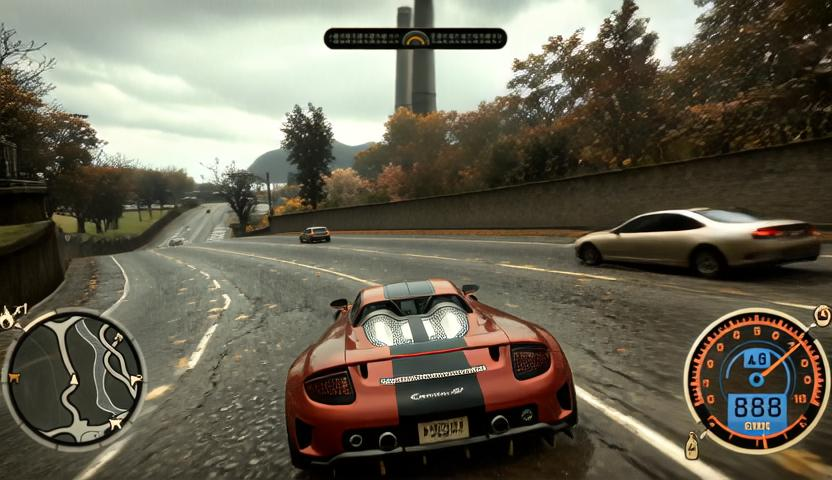
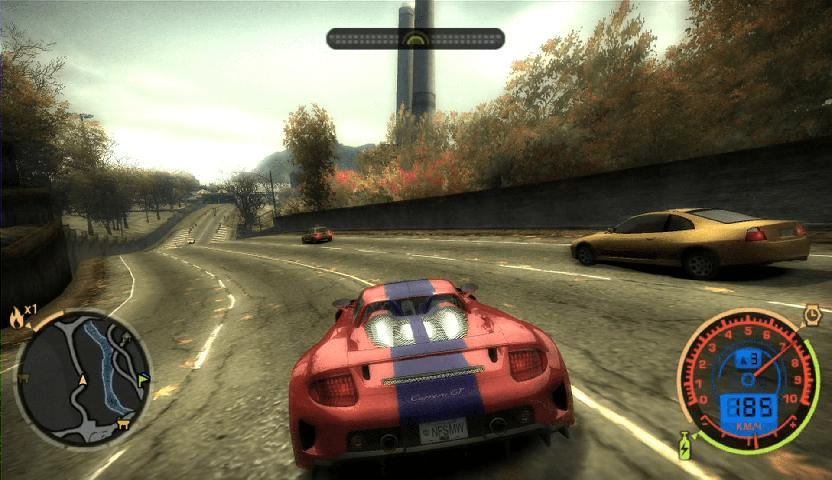

In [84]:
from jupyter_compare_view import compare

# pos = 520
pos = 640
compare(
    Image.open(styled_images[pos]).resize((832, 480)).convert("RGB"),
    Image.open(original_images[pos]).resize((832, 480)).convert("RGB"),
    cmap="gray",
    start_mode="horizontal",
    start_slider_pos=0.53,
)

In [5]:
from datasets import load_dataset
import shutil
import os

# dataset_name = "dim/nfs_pix2pix_1920_1080_v5"
dataset_name = "dim/nfs_pix2pix_1920_1080_v6"
dataset = load_dataset(
    dataset_name,
    # cache_dir="/code/dataset/nfs_pix2pix_1920_1080_v5",
    cache_dir="/code/dataset/nfs_pix2pix_1920_1080_v6",
)
dataset = dataset["train"]

save_path_folder = (
    "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1_wan_mix_hf"
    # "/code/comfyui_sandbox/video_renders/render_nfs_4screens_5_sdxl_1_original/"
)
os.system(f"mkdir -p {save_path_folder}")


def save_folder(example, idx):
    try:
        num = "{:07d}".format(idx)
        shutil.copyfile(
            f"{styled_images_path}/{num}.png",
            f"{save_path_folder}/{num}_edited_image.png",
        )
        example["input_image"].resize((832, 480)).save(
            f"{save_path_folder}/{num}_input_image.png"
        )
    except:
        pass


dataset.map(
    save_folder,
    num_proc=20,
    with_indices=True,
)

Resolving data files:   0%|          | 0/190 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/190 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/173 [00:00<?, ?it/s]

Map (num_proc=20):   0%|          | 0/49424 [00:00<?, ? examples/s]

Dataset({
    features: ['input_image', 'edit_prompt', 'edited_image'],
    num_rows: 49424
})

In [16]:
import os
from pathlib import Path
from PIL import Image
import pandas as pd

combined_images_path = (
    "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1_wan_mix_hf"
)
combined_images = sorted(list(Path(combined_images_path).glob("*.png")))
# last_image = combined_images[-1].stem.split('_')[0]

# for num in range(last_image):
input_images = [item for item in combined_images if "input_image" in item.name]
edited_images = [item for item in combined_images if "edited_image" in item.name]
metadata = []
for input_image, edited_image in zip(input_images, edited_images):
    metadata.append(
        {
            "input_image_file_name": input_image.name,
            "edited_image_file_name": edited_image.name,
            "edit_prompt": "",
        }
    )
pd.DataFrame.from_records(metadata).to_csv(f"{combined_images_path}/metadata.csv")

In [2]:
from datasets import Dataset, load_dataset

save_path_folder = (
    "/code/comfyui_sandbox/video_renders/render_nfs_4screens_6_sdxl_1_wan_mix_hf"
    # "/code/comfyui_sandbox/video_renders/render_nfs_4screens_5_sdxl_1_original/"
)
new_dataset = load_dataset(save_path_folder)

Resolving data files:   0%|          | 0/98707 [00:00<?, ?it/s]

In [3]:
new_dataset = new_dataset["train"]


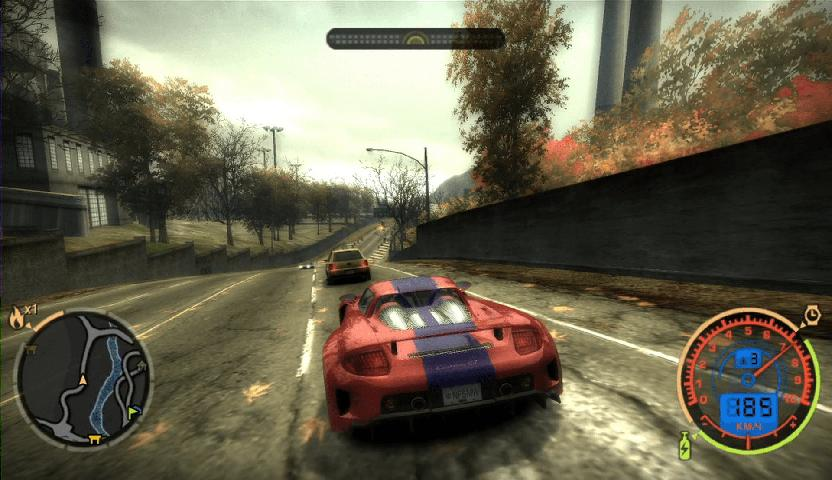
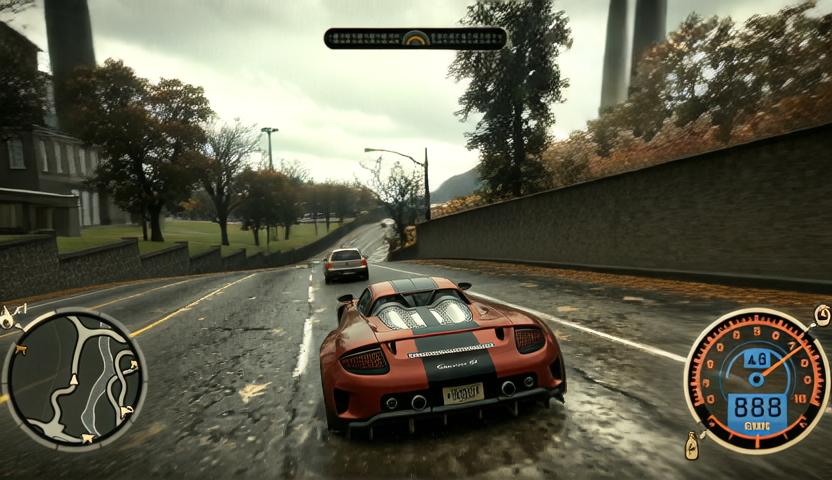

In [5]:
from jupyter_compare_view import compare

# pos = 184
pos = 654
# pos = 754
# pos = 49000
compare(
    new_dataset[pos]["input_image"].convert("RGB"),
    new_dataset[pos]["edited_image"].convert("RGB"),
    cmap="gray",
    start_mode="horizontal",
    start_slider_pos=0.53,
)

In [8]:
import os

os.environ["https_proxy"] = "127.0.0.1:2334"
new_dataset.push_to_hub(
    "dim/render_nfs_4screens_6_sdxl_1_wan_mix",
    num_proc=20,
)

Uploading the dataset shards (num_proc=20):   0%|          | 0/85 [00:00<?, ? shards/s]

CommitInfo(commit_url='https://huggingface.co/datasets/dim/render_nfs_4screens_6_sdxl_1_wan_mix/commit/a2493e6c4dda1926da1ec0f4a201b1de6dce9d8b', commit_message='Upload dataset', commit_description='', oid='a2493e6c4dda1926da1ec0f4a201b1de6dce9d8b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/dim/render_nfs_4screens_6_sdxl_1_wan_mix', endpoint='https://huggingface.co', repo_type='dataset', repo_id='dim/render_nfs_4screens_6_sdxl_1_wan_mix'), pr_revision=None, pr_num=None)